In [11]:
!pip install scikit-allel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 7.1 MB/s eta 0:00:0000:0100:01m


In [12]:
import allel
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.stats import gaussian_kde, entropy, spearmanr
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import networkx as nx
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
import itertools
from sklearn.neighbors import KernelDensity
from scipy.stats import chi2_contingency

In [ ]:
vcf_path = r"..data//genotypes.vcf"
callset = allel.read_vcf(vcf_path)

/opt/conda/lib/python3.10/site-packages/allel/io/vcf_read.py:1732: UserWarning: invalid INFO header: '##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)",Version="3">\n'
  warnings.warn('invalid INFO header: %r' % header)


In [24]:
# Создаем фигуру с несколькими подграфиками
plt.style.use('seaborn')
fig = plt.figure(figsize=(15, 12))

/tmp/ipykernel_30/1739253348.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<Figure size 1500x1200 with 0 Axes>

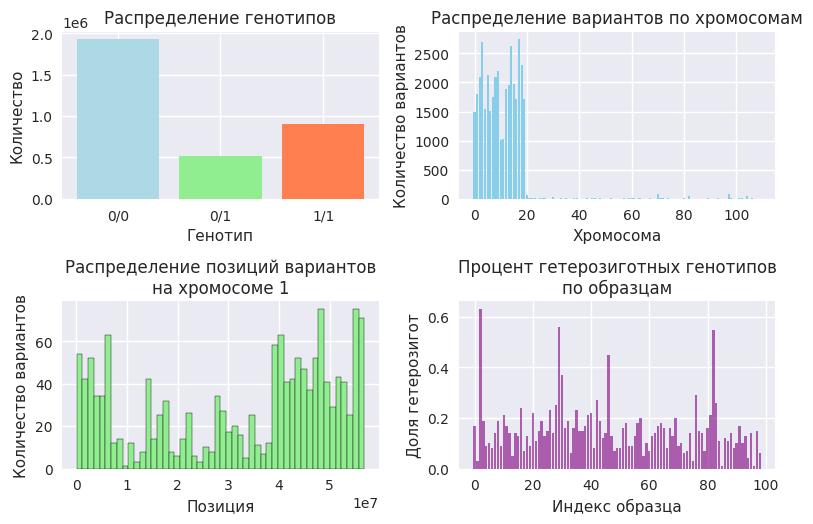

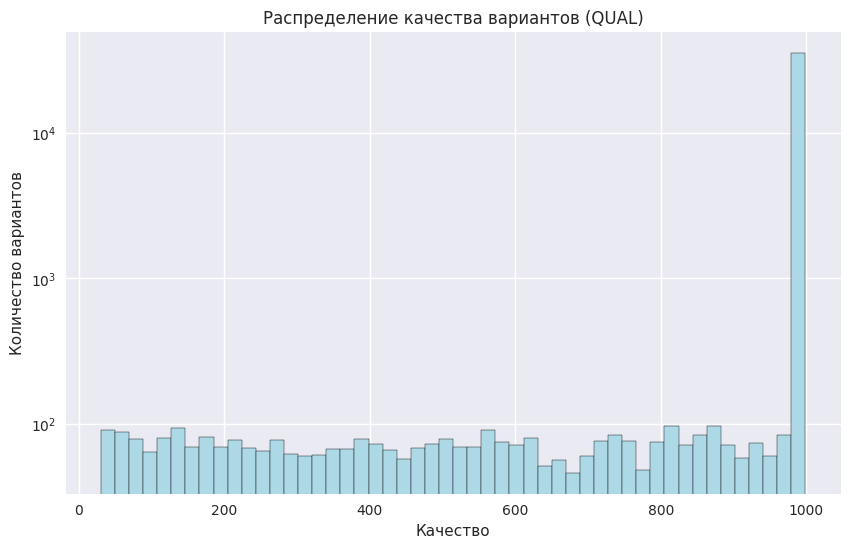


Статистика по образцам:
Всего вариантов: 38940
Всего образцов: 99

Топ-5 образцов с наибольшей гетерозиготностью:
Образец PS000028: 33.42% гетерозигот
Образец PS000115: 33.20% гетерозигот
Образец PS000078: 32.42% гетерозигот
Образец PS000210: 27.28% гетерозигот
Образец PS000079: 25.73% гетерозигот


In [36]:
# 1. Распределение генотипов
gt = callset['calldata/GT']
genotype_counts = np.zeros((3,))  # для 0/0, 0/1, 1/1

for sample_gts in gt.reshape(-1, 2):  # Преобразуем в 2D массив генотипов
    if np.array_equal(sample_gts, [0, 0]):
        genotype_counts[0] += 1
    elif np.array_equal(sample_gts, [0, 1]) or np.array_equal(sample_gts, [1, 0]):
        genotype_counts[1] += 1
    elif np.array_equal(sample_gts, [1, 1]):
        genotype_counts[2] += 1

plt.subplot(2, 2, 1)
plt.bar(['0/0', '0/1', '1/1'], genotype_counts, color=['lightblue', 'lightgreen', 'coral'])
plt.title('Распределение генотипов')
plt.ylabel('Количество')
plt.xlabel('Генотип')

# 2. Распределение вариантов по хромосомам
plt.subplot(2, 2, 2)
chrom = callset['variants/CHROM']
chrom_counts = dict(zip(*np.unique(chrom, return_counts=True)))
sorted_chroms = sorted(chrom_counts.keys(), 
                      key=lambda x: (len(x), int(x.replace('KZ848124', '999')) if x.isdigit() else 999))
counts = [chrom_counts[c] for c in sorted_chroms]
plt.bar(range(len(sorted_chroms)), counts, color='skyblue')
# Убрали эту строку: plt.xticks(range(len(sorted_chroms)), sorted_chroms, rotation=45)
plt.title('Распределение вариантов по хромосомам')
plt.xlabel('Хромосома')
plt.ylabel('Количество вариантов')

# 3. Распределение позиций вариантов на выбранной хромосоме
plt.subplot(2, 2, 3)
chrom_1_mask = chrom == '1'
pos_chrom_1 = callset['variants/POS'][chrom_1_mask]
plt.hist(pos_chrom_1, bins=50, color='lightgreen', edgecolor='black')
plt.title('Распределение позиций вариантов\nна хромосоме 1')
plt.xlabel('Позиция')
plt.ylabel('Количество вариантов')

# 4. Карта генотипов по образцам
plt.subplot(2, 2, 4)
sample_heterozygosity = []
n_samples = gt.shape[1]
n_variants = min(100, gt.shape[0])  # Берем первые 100 вариантов для наглядности

# Вычисляем процент гетерозиготных генотипов для каждого образца
for i in range(n_samples):
    sample_gts = gt[:n_variants, i]
    het_count = sum(1 for gt in sample_gts if np.array_equal(gt, [0, 1]) or np.array_equal(gt, [1, 0]))
    sample_heterozygosity.append(het_count / n_variants)

plt.bar(range(n_samples), sample_heterozygosity, color='purple', alpha=0.6)
plt.title('Процент гетерозиготных генотипов\nпо образцам')
plt.xlabel('Индекс образца')
plt.ylabel('Доля гетерозигот')

plt.tight_layout()
plt.show()

# 5. Дополнительный график: распределение качества вариантов
plt.figure(figsize=(10, 6))
qual = callset['variants/QUAL']
plt.hist(qual, bins=50, color='lightblue', edgecolor='black')
plt.title('Распределение качества вариантов (QUAL)')
plt.xlabel('Качество')
plt.ylabel('Количество вариантов')
plt.yscale('log')  # Используем логарифмическую шкалу для лучшей визуализации
plt.show()

# 6. Статистика по образцам
total_variants = gt.shape[0]
n_samples = gt.shape[1]
sample_names = callset['samples']

print("\nСтатистика по образцам:")
print(f"Всего вариантов: {total_variants}")
print(f"Всего образцов: {n_samples}")

# Вычисляем статистику по генотипам для каждого образца
het_stats = []
for i, sample in enumerate(sample_names):
    sample_gts = gt[:, i]
    het_count = sum(1 for gt in sample_gts if np.array_equal(gt, [0, 1]) or np.array_equal(gt, [1, 0]))
    hom_ref_count = sum(1 for gt in sample_gts if np.array_equal(gt, [0, 0]))
    hom_alt_count = sum(1 for gt in sample_gts if np.array_equal(gt, [1, 1]))
    het_stats.append({
        'sample': sample,
        'het_ratio': het_count / total_variants,
        'hom_ref_ratio': hom_ref_count / total_variants,
        'hom_alt_ratio': hom_alt_count / total_variants
    })

# Выводим топ-5 образцов с наибольшей гетерозиготностью
print("\nТоп-5 образцов с наибольшей гетерозиготностью:")
sorted_stats = sorted(het_stats, key=lambda x: x['het_ratio'], reverse=True)
for stat in sorted_stats[:5]:
    print(f"Образец {stat['sample']}: {stat['het_ratio']:.2%} гетерозигот")

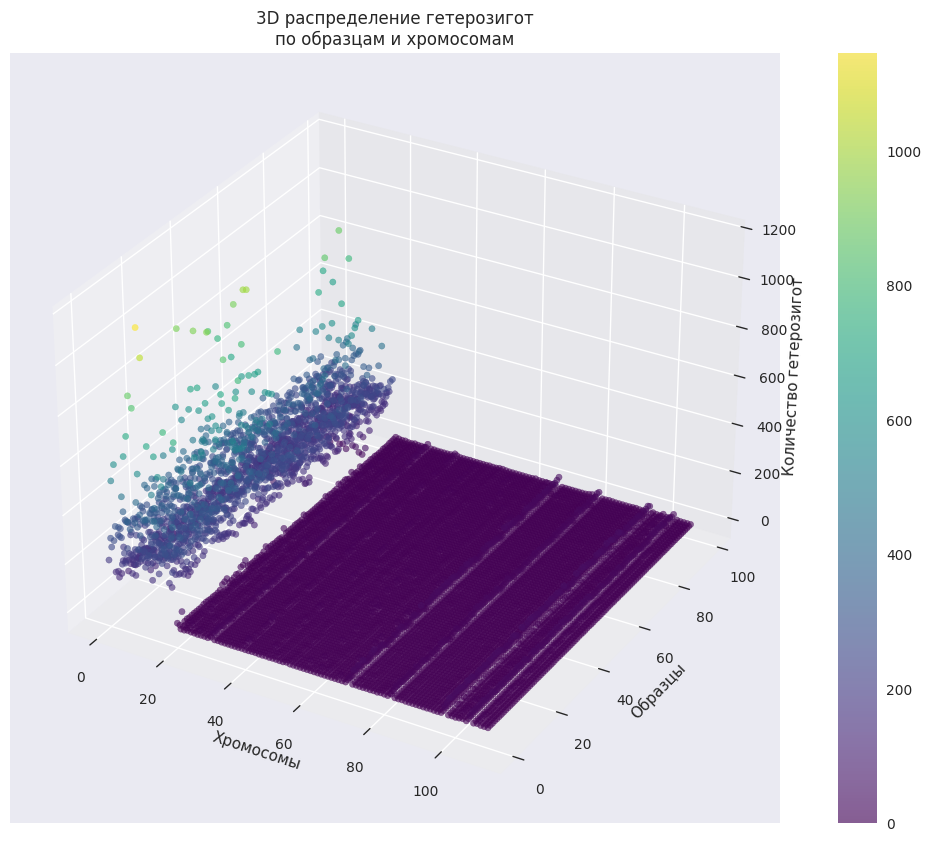

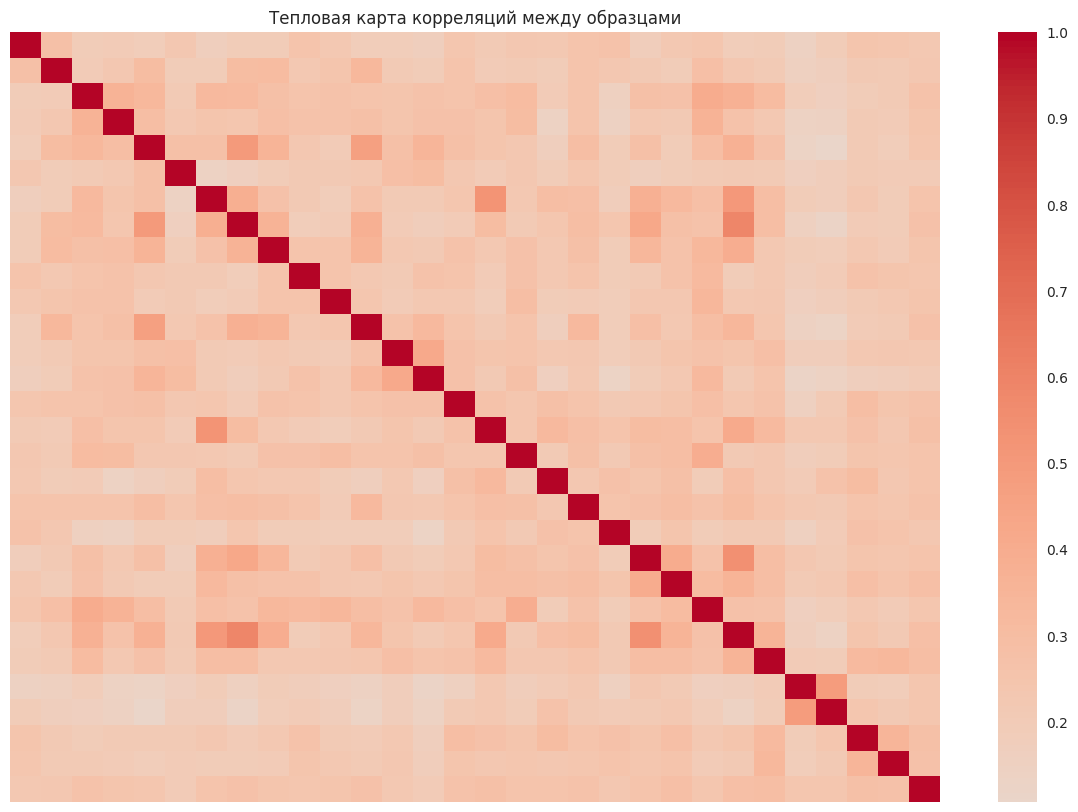

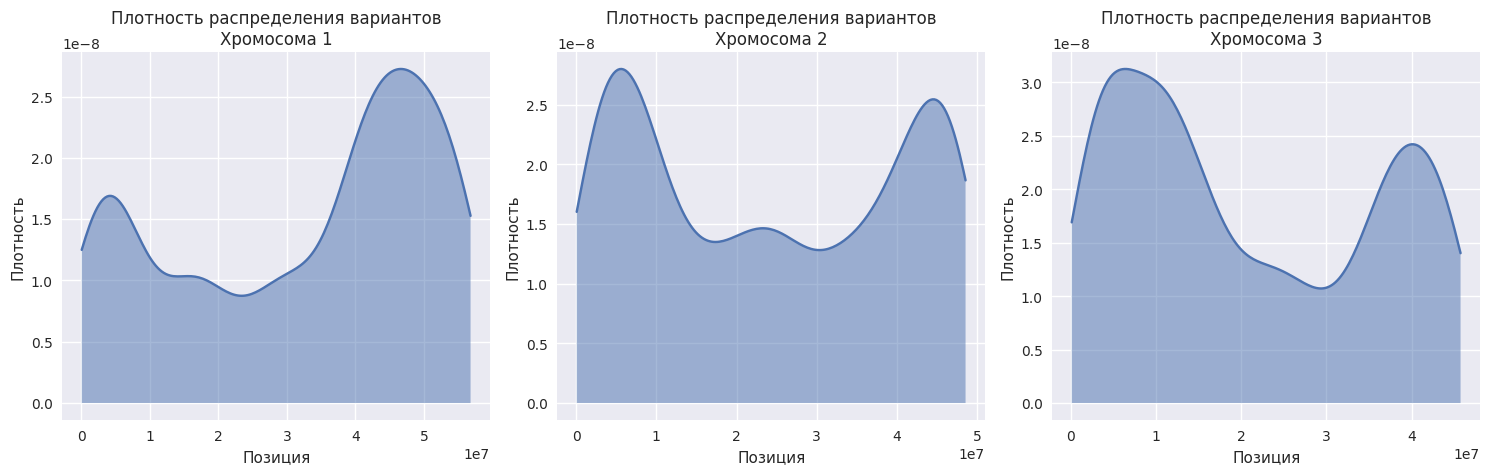

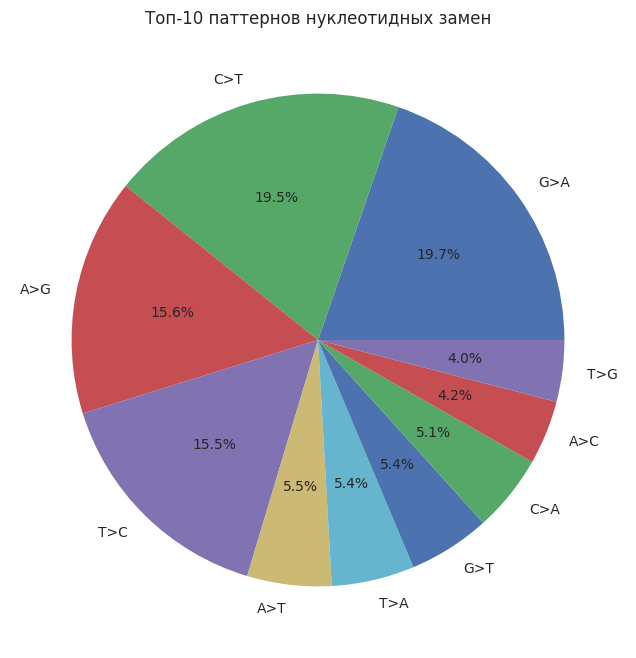

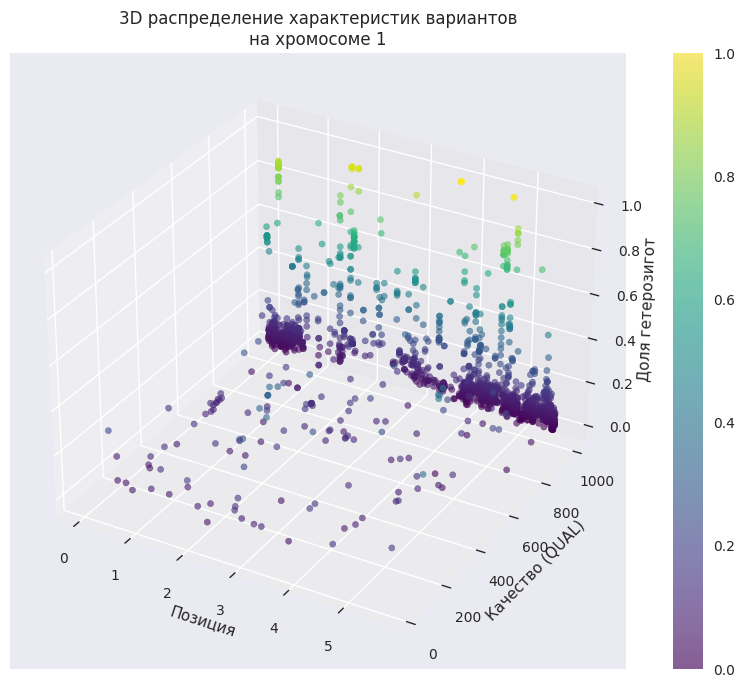


Статистика по нуклеотидным заменам:
G>A: 6515 случаев (18.4%)
C>T: 6461 случаев (18.2%)
A>G: 5145 случаев (14.5%)
T>C: 5137 случаев (14.5%)
A>T: 1829 случаев (5.2%)
T>A: 1797 случаев (5.1%)
G>T: 1773 случаев (5.0%)
C>A: 1677 случаев (4.7%)
A>C: 1386 случаев (3.9%)
T>G: 1336 случаев (3.8%)

Статистика по гетерозиготности:
Средняя доля гетерозигот: 0.175
Медианная доля гетерозигот: 0.101
Максимальная доля гетерозигот: 1.000


In [37]:
# 1. 3D график распределения генотипов по образцам и хромосомам
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Подготавливаем данные
gt = callset['calldata/GT']
chroms = callset['variants/CHROM']
n_samples = gt.shape[1]
n_variants = gt.shape[0]

# Создаем массивы для координат
x_coords = []  # хромосомы
y_coords = []  # образцы
z_coords = []  # количество гетерозигот

unique_chroms = np.unique(chroms)
chrom_to_idx = {chrom: idx for idx, chrom in enumerate(unique_chroms)}

for i in range(n_samples):
    for chrom in unique_chroms:
        mask = chroms == chrom
        sample_gts = gt[mask, i]
        het_count = sum(1 for gt in sample_gts if np.array_equal(gt, [0, 1]) or np.array_equal(gt, [1, 0]))
        x_coords.append(chrom_to_idx[chrom])
        y_coords.append(i)
        z_coords.append(het_count)

scatter = ax.scatter(x_coords, y_coords, z_coords, c=z_coords, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
ax.set_xlabel('Хромосомы')
ax.set_ylabel('Образцы')
ax.set_zlabel('Количество гетерозигот')
ax.set_title('3D распределение гетерозигот\nпо образцам и хромосомам')
plt.show()

# 2. Тепловая карта корреляций между образцами
plt.figure(figsize=(15, 10))

# Создаем матрицу корреляций между образцами
n_samples_for_corr = min(30, n_samples)  # Ограничиваем количество образцов для наглядности
correlation_matrix = np.zeros((n_samples_for_corr, n_samples_for_corr))

for i in range(n_samples_for_corr):
    for j in range(n_samples_for_corr):
        # Считаем корреляцию между генотипами образцов
        gts_i = np.sum(gt[:, i], axis=1)
        gts_j = np.sum(gt[:, j], axis=1)
        correlation = np.corrcoef(gts_i, gts_j)[0, 1]
        correlation_matrix[i, j] = correlation

sns.heatmap(correlation_matrix, cmap='coolwarm', center=0,
            xticklabels=False, yticklabels=False)
plt.title('Тепловая карта корреляций между образцами')
plt.show()

# 3. Плотность распределения вариантов по позициям для первых трех хромосом
plt.figure(figsize=(15, 5))

for idx, chrom in enumerate(['1', '2', '3']):
    plt.subplot(1, 3, idx + 1)
    mask = chroms == chrom
    positions = callset['variants/POS'][mask]
    
    if len(positions) > 0:
        # Оценка плотности распределения
        kernel = gaussian_kde(positions)
        x_range = np.linspace(min(positions), max(positions), 200)
        density = kernel(x_range)
        
        plt.plot(x_range, density)
        plt.fill_between(x_range, density, alpha=0.5)
        plt.title(f'Плотность распределения вариантов\nХромосома {chrom}')
        plt.xlabel('Позиция')
        plt.ylabel('Плотность')

plt.tight_layout()
plt.show()

# 4. Круговая диаграмма соотношения REF/ALT для топ-10 паттернов замен
plt.figure(figsize=(12, 8))

ref = callset['variants/REF']
alt = callset['variants/ALT'][:, 0]  # Берем первый альтернативный аллель
substitutions = {}

for r, a in zip(ref, alt):
    if len(r) == 1 and len(a) == 1 and a != '':  # Только однонуклеотидные замены
        key = f'{r}>{a}'
        substitutions[key] = substitutions.get(key, 0) + 1

# Берем топ-10 паттернов замен
top_substitutions = dict(sorted(substitutions.items(), key=lambda x: x[1], reverse=True)[:10])

plt.pie(top_substitutions.values(), labels=top_substitutions.keys(), autopct='%1.1f%%')
plt.title('Топ-10 паттернов нуклеотидных замен')
plt.show()

# 5. 3D scatter plot качества, позиции и гетерозиготности
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Выберем данные для первой хромосомы для наглядности
chrom_mask = chroms == '1'
positions = callset['variants/POS'][chrom_mask]
qual = callset['variants/QUAL'][chrom_mask]

# Подсчитаем гетерозиготность для каждого варианта
het_rates = []
for variant_gt in gt[chrom_mask]:
    het_count = sum(1 for gt in variant_gt if np.array_equal(gt, [0, 1]) or np.array_equal(gt, [1, 0]))
    het_rates.append(het_count / n_samples)

scatter = ax.scatter(positions, qual, het_rates, 
                    c=het_rates, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
ax.set_xlabel('Позиция')
ax.set_ylabel('Качество (QUAL)')
ax.set_zlabel('Доля гетерозигот')
ax.set_title('3D распределение характеристик вариантов\nна хромосоме 1')
plt.show()

# Выведем некоторую статистику
print("\nСтатистика по нуклеотидным заменам:")
for pattern, count in top_substitutions.items():
    print(f"{pattern}: {count} случаев ({count/sum(substitutions.values())*100:.1f}%)")

print("\nСтатистика по гетерозиготности:")
print(f"Средняя доля гетерозигот: {np.mean(het_rates):.3f}")
print(f"Медианная доля гетерозигот: {np.median(het_rates):.3f}")
print(f"Максимальная доля гетерозигот: {np.max(het_rates):.3f}")

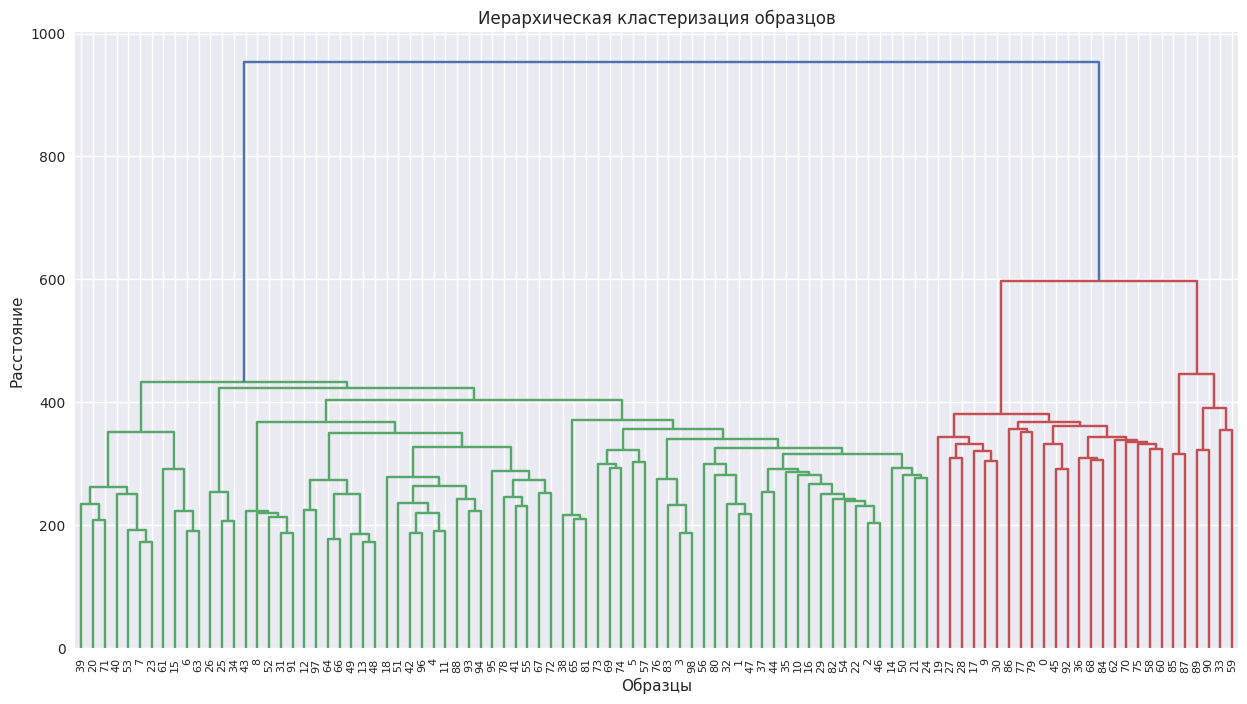

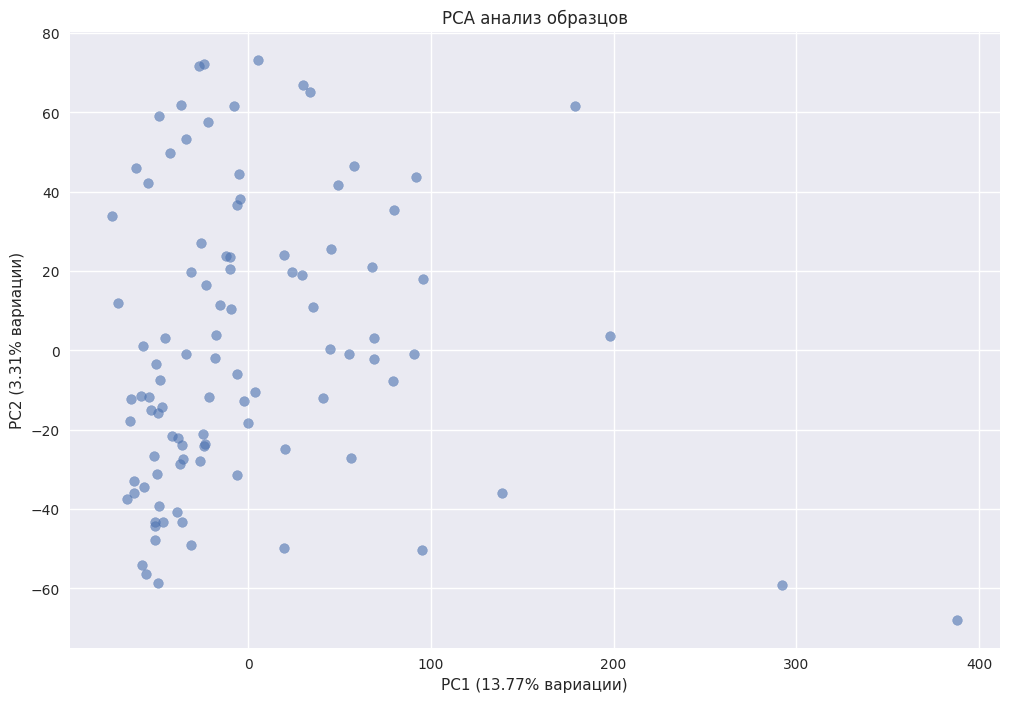

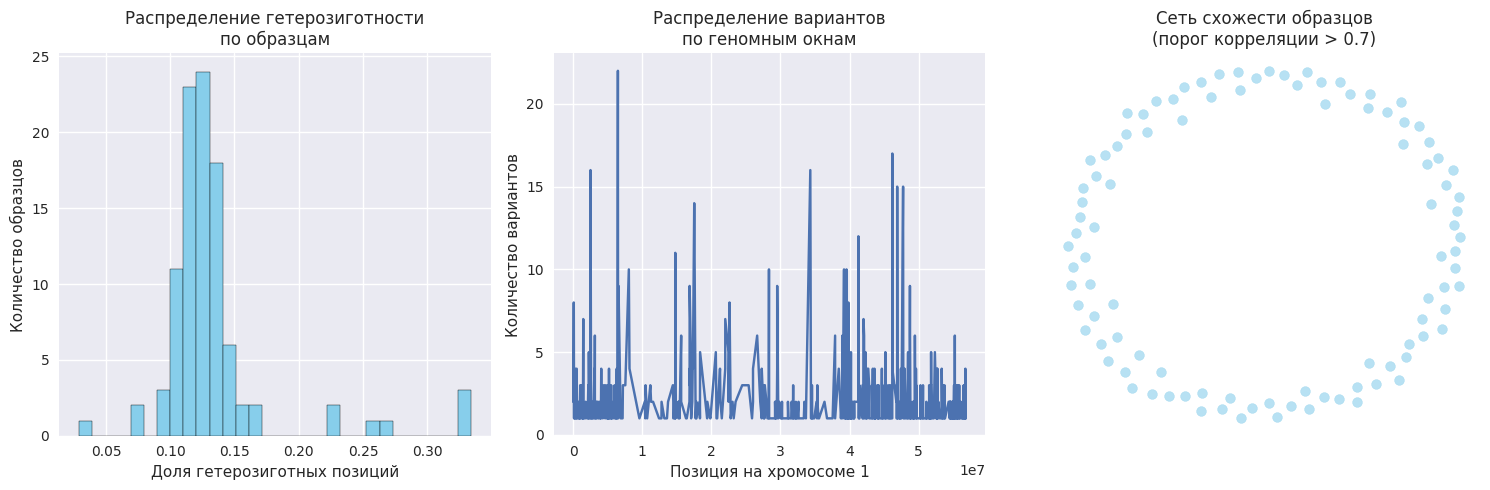

In [39]:
# 1. Иерархическая кластеризация образцов
plt.figure(figsize=(15, 8))

# Создаем матрицу признаков для образцов
gt = callset['calldata/GT']
n_samples = gt.shape[1]
n_variants = gt.shape[0]

# Преобразуем генотипы в числовые значения (0,1,2 для 0/0, 0/1, 1/1)
sample_features = np.zeros((n_samples, n_variants))
for i in range(n_samples):
    for j in range(n_variants):
        gt_sum = sum(gt[j, i])
        sample_features[i, j] = gt_sum

# Вычисляем дистанции и строим дендрограмму
Z = linkage(sample_features, method='ward')
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.title('Иерархическая кластеризация образцов')
plt.xlabel('Образцы')
plt.ylabel('Расстояние')
plt.show()

# 2. PCA анализ
plt.figure(figsize=(12, 8))

# Нормализуем данные
scaler = StandardScaler()
sample_features_scaled = scaler.fit_transform(sample_features)

# Применяем PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sample_features_scaled)

plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
plt.title('PCA анализ образцов')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} вариации)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} вариации)')
plt.show()

# 3. Анализ паттернов гетерозиготности
plt.figure(figsize=(15, 5))

# Вычисляем паттерны гетерозиготности для каждого образца
het_patterns = np.zeros(n_samples)
for i in range(n_samples):
    sample_gts = gt[:, i]
    het_count = sum(1 for gt in sample_gts if np.array_equal(gt, [0, 1]) or np.array_equal(gt, [1, 0]))
    het_patterns[i] = het_count / n_variants

# Создаем график распределения гетерозиготности
plt.subplot(131)
plt.hist(het_patterns, bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение гетерозиготности\nпо образцам')
plt.xlabel('Доля гетерозиготных позиций')
plt.ylabel('Количество образцов')

# 4. Анализ "окон" вариабельности
window_size = 1000  # размер окна в base pairs
chrom = callset['variants/CHROM']
pos = callset['variants/POS']

# Выбираем первую хромосому для демонстрации
chrom_1_mask = chrom == '1'
pos_chrom_1 = pos[chrom_1_mask]
gt_chrom_1 = gt[chrom_1_mask]

if len(pos_chrom_1) > 0:
    windows = {}
    max_pos = max(pos_chrom_1)
    
    for i in range(0, max_pos, window_size):
        window_mask = (pos_chrom_1 >= i) & (pos_chrom_1 < i + window_size)
        if np.any(window_mask):
            windows[i] = np.sum(window_mask)

    plt.subplot(132)
    plt.plot(list(windows.keys()), list(windows.values()), '-')
    plt.title('Распределение вариантов\nпо геномным окнам')
    plt.xlabel('Позиция на хромосоме 1')
    plt.ylabel('Количество вариантов')

# 5. Сетевой анализ схожести образцов
similarity_matrix = np.corrcoef(sample_features)
threshold = 0.7  # порог схожести для создания связи

# Создаем граф
G = nx.Graph()
for i in range(n_samples):
    G.add_node(i)
    for j in range(i+1, n_samples):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

plt.subplot(133)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=50, node_color='skyblue', 
        edge_color='gray', alpha=0.6)
plt.title('Сеть схожести образцов\n(порог корреляции > 0.7)')

plt.tight_layout()
plt.show()

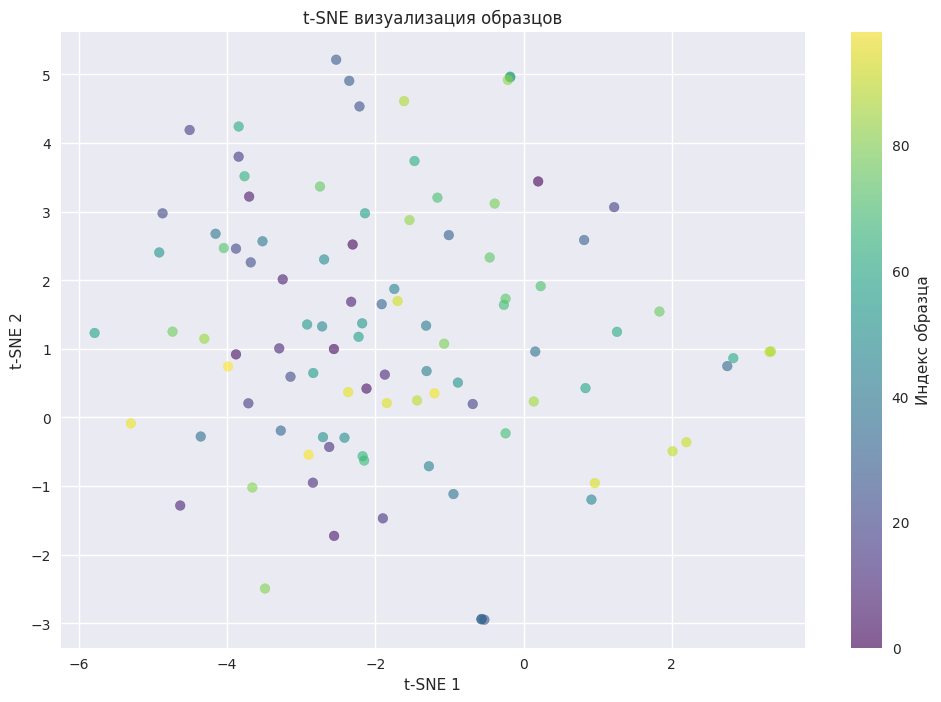

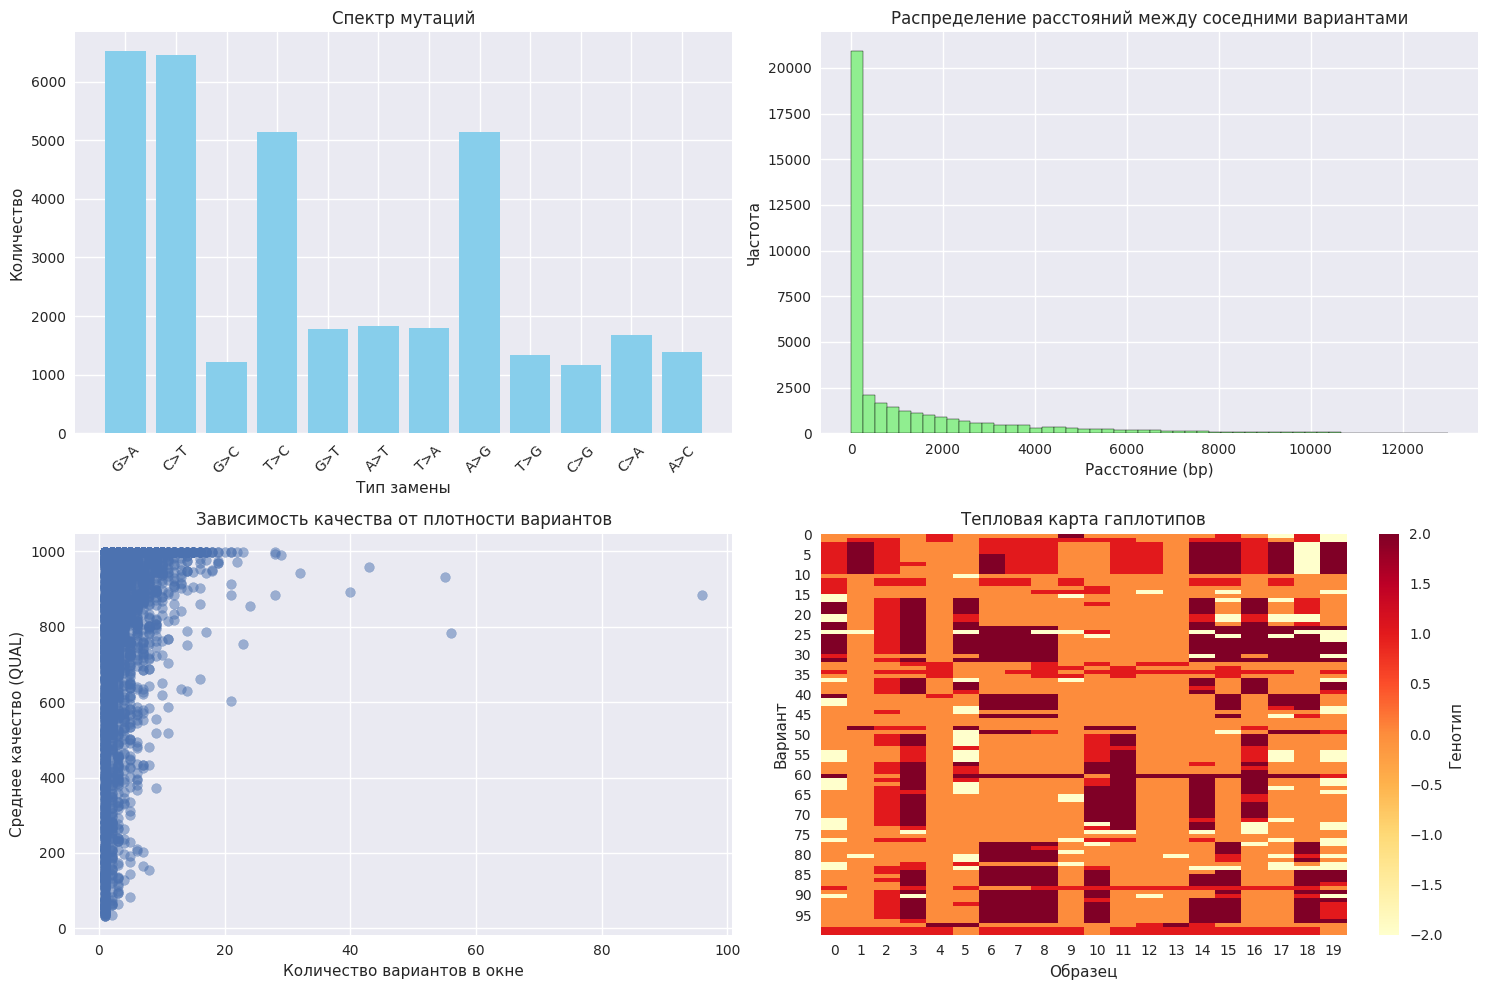

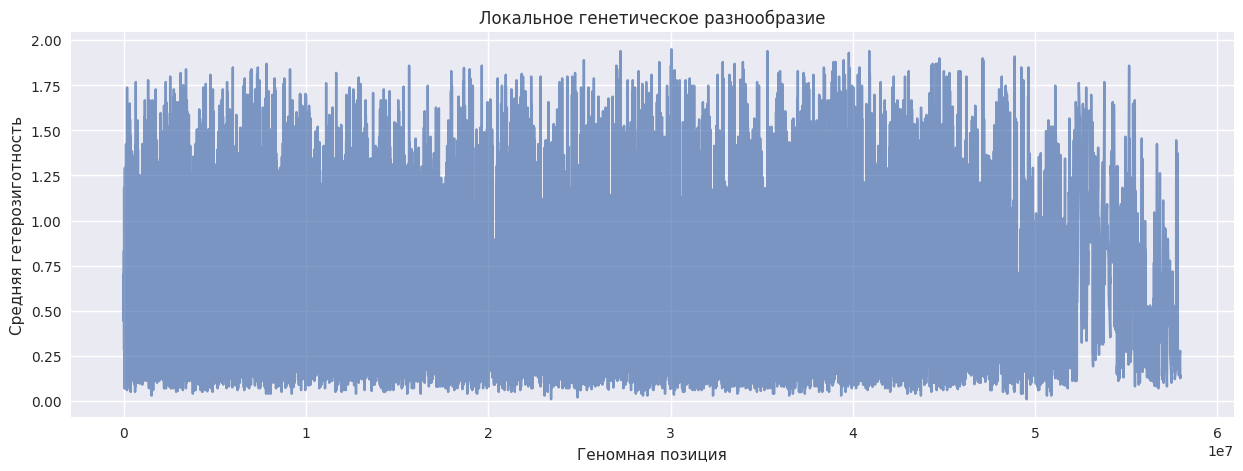

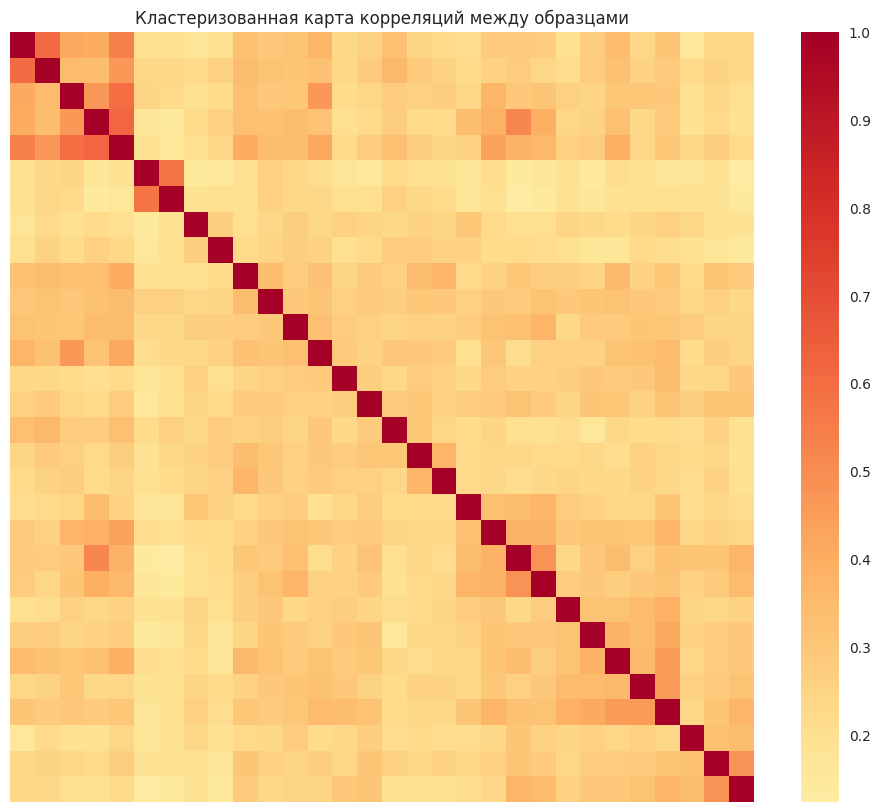


Расширенная статистика анализа:
Общее количество вариантов: 38940
Среднее расстояние между вариантами: 1489.48 bp
Медианное расстояние между вариантами: 169.00 bp

Топ-5 типов мутаций:
G>A: 6515 (18.4%)
C>T: 6461 (18.2%)
A>G: 5145 (14.5%)
T>C: 5137 (14.5%)
A>T: 1829 (5.2%)


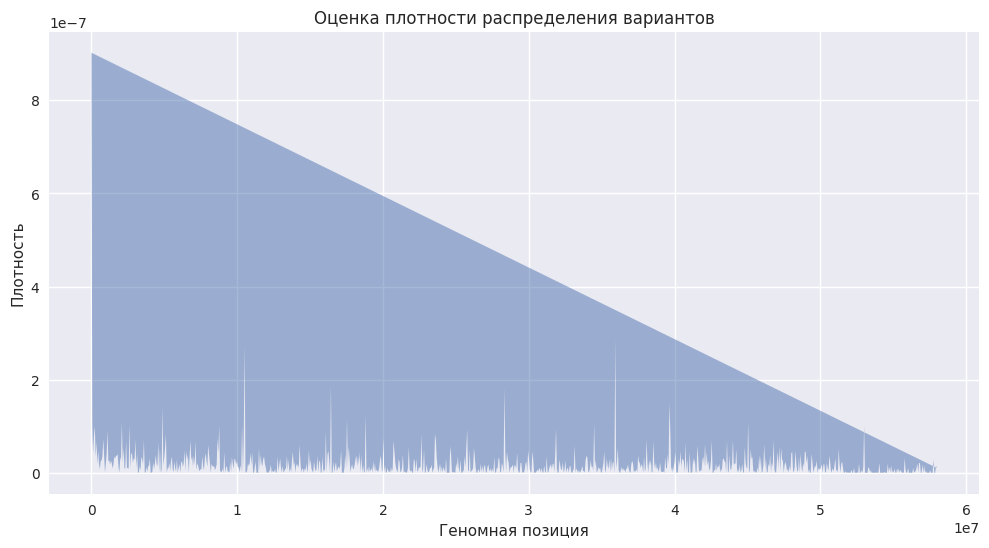

In [40]:
# 1. t-SNE визуализация для нелинейного отображения данных
plt.figure(figsize=(12, 8))

# Подготовка данных для t-SNE
gt = callset['calldata/GT']
n_samples = gt.shape[1]
n_variants = gt.shape[0]

# Преобразуем генотипы в числовые значения
sample_features = np.array([[sum(gt[j, i]) for j in range(n_variants)] 
                           for i in range(n_samples)])

# Применяем t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(sample_features)

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=range(n_samples), 
            cmap='viridis', alpha=0.6)
plt.colorbar(label='Индекс образца')
plt.title('t-SNE визуализация образцов')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

# 2. Анализ мутационных сигнатур
plt.figure(figsize=(15, 10))

# Создаем контекстные триплеты
ref = callset['variants/REF']
alt = callset['variants/ALT'][:, 0]
trinucleotide_counts = {}

for r, a in zip(ref, alt):
    if len(r) == 1 and len(a) == 1 and a != '':
        key = f'{r}>{a}'
        trinucleotide_counts[key] = trinucleotide_counts.get(key, 0) + 1

# Визуализируем спектр мутаций
labels = list(trinucleotide_counts.keys())
values = list(trinucleotide_counts.values())

plt.subplot(2, 2, 1)
plt.bar(range(len(labels)), values, color='skyblue')
plt.xticks(range(len(labels)), labels, rotation=45)
plt.title('Спектр мутаций')
plt.xlabel('Тип замены')
plt.ylabel('Количество')

# 3. Анализ кластеров вариантов
positions = callset['variants/POS']
qual = callset['variants/QUAL']

# Находим кластеры близких вариантов
plt.subplot(2, 2, 2)
distances = np.diff(sorted(positions))
plt.hist(distances[distances < np.percentile(distances, 99)], 
         bins=50, color='lightgreen', edgecolor='black')
plt.title('Распределение расстояний между соседними вариантами')
plt.xlabel('Расстояние (bp)')
plt.ylabel('Частота')

# 4. Комплексный анализ качества
plt.subplot(2, 2, 3)
variant_density = []
qual_density = []

# Используем скользящее окно для анализа
window_size = 1000
for i in range(0, max(positions), window_size):
    mask = (positions >= i) & (positions < i + window_size)
    if np.sum(mask) > 0:
        variant_density.append(np.sum(mask))
        qual_density.append(np.mean(qual[mask]))

plt.scatter(variant_density, qual_density, alpha=0.5)
plt.title('Зависимость качества от плотности вариантов')
plt.xlabel('Количество вариантов в окне')
plt.ylabel('Среднее качество (QUAL)')

# 5. Анализ гаплотипов
plt.subplot(2, 2, 4)
# Создаем матрицу гаплотипов для первых 100 вариантов и 20 образцов
haplotype_matrix = np.zeros((min(100, n_variants), min(20, n_samples)))
for i in range(min(100, n_variants)):
    for j in range(min(20, n_samples)):
        haplotype_matrix[i, j] = sum(gt[i, j])

sns.heatmap(haplotype_matrix, cmap='YlOrRd', cbar_kws={'label': 'Генотип'})
plt.title('Тепловая карта гаплотипов')
plt.xlabel('Образец')
plt.ylabel('Вариант')

plt.tight_layout()
plt.show()

# 6. Анализ локального разнообразия
plt.figure(figsize=(15, 5))

# Вычисляем метрики разнообразия в окнах
window_size = 1000
diversity_metrics = []
positions_windows = []

for i in range(0, max(positions), window_size):
    mask = (positions >= i) & (positions < i + window_size)
    if np.sum(mask) > 0:
        window_gt = gt[mask]
        # Считаем среднюю гетерозиготность в окне
        het_rate = np.mean([np.sum(sample_gt == 1) for sample_gt in window_gt.reshape(-1, 2)])
        diversity_metrics.append(het_rate)
        positions_windows.append(i)

plt.plot(positions_windows, diversity_metrics, '-', alpha=0.7)
plt.title('Локальное генетическое разнообразие')
plt.xlabel('Геномная позиция')
plt.ylabel('Средняя гетерозиготность')
plt.show()

# 7. Создаем интерактивную тепловую карту корреляций между образцами
plt.figure(figsize=(12, 10))

# Вычисляем корреляции между первыми 30 образцами
n_samples_corr = min(30, n_samples)
correlation_matrix = np.zeros((n_samples_corr, n_samples_corr))

for i in range(n_samples_corr):
    for j in range(n_samples_corr):
        gts_i = np.sum(gt[:, i], axis=1)
        gts_j = np.sum(gt[:, j], axis=1)
        correlation_matrix[i, j], _ = spearmanr(gts_i, gts_j)

# Кластеризуем корреляционную матрицу
linkage_matrix = hierarchy.linkage(pdist(correlation_matrix), method='ward')
ordered_idx = hierarchy.leaves_list(linkage_matrix)
ordered_corr = correlation_matrix[ordered_idx][:, ordered_idx]

sns.heatmap(ordered_corr, cmap='RdYlBu_r', center=0,
            xticklabels=False, yticklabels=False)
plt.title('Кластеризованная карта корреляций между образцами')
plt.show()

# Выводим статистику
print("\nРасширенная статистика анализа:")
print(f"Общее количество вариантов: {n_variants}")
print(f"Среднее расстояние между вариантами: {np.mean(distances):.2f} bp")
print(f"Медианное расстояние между вариантами: {np.median(distances):.2f} bp")
print("\nТоп-5 типов мутаций:")
sorted_mutations = sorted(trinucleotide_counts.items(), key=lambda x: x[1], reverse=True)
for mut, count in sorted_mutations[:5]:
    print(f"{mut}: {count} ({count/sum(trinucleotide_counts.values())*100:.1f}%)")

# 8. Анализ плотности вариантов с использованием KDE
plt.figure(figsize=(12, 6))

# Используем KDE для оценки плотности вариантов
kde = KernelDensity(bandwidth=1000)
X = positions.reshape(-1, 1)
kde.fit(X)

# Создаем точки для построения графика
X_plot = np.linspace(min(positions), max(positions), 1000).reshape(-1, 1)
log_dens = kde.score_samples(X_plot)

plt.fill(X_plot.ravel(), np.exp(log_dens), alpha=0.5)
plt.title('Оценка плотности распределения вариантов')
plt.xlabel('Геномная позиция')
plt.ylabel('Плотность')
plt.show()